In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
import pyarrow.parquet as pq
import contextily as ctx
from pyproj import Proj, transform
import haversine as hs
from sklearn.cluster import KMeans, MeanShift
import scipy.stats
import statsmodels.api as sm
import random
import mobilkit
from fastdtw import fastdtw
import seaborn as sns
from causalimpact import CausalImpact
from factor_analyzer import FactorAnalyzer
import pyarrow as pa
import os
from datetime import datetime
from progressbar import ProgressBar
pbar = ProgressBar()
from dask import dataframe as dd 

In [2]:
path = '/home/umni2/a/umnilab/data/WB_India2/'
month = "01"
year = "2020"
dates = []
for cnt in range(0, 1):
    day = str(cnt+1)
    if cnt+1<10:
        day = "0" + str(cnt+1)
    dates.append("date="+year+"-"+month+"-"+day)

added = 0
for cnt in pbar(range(0, len(dates))):
    path_ = path+dates[cnt]
    files = os.listdir(path_)
    for f in files:
        if ".snappy.parquet" in f:
            table2 = pq.read_table(path_+'/'+f)
            file = table2.to_pandas()
            if added==0:
                df = file
                added = added + 1
            else:
                df = df.append(file, ignore_index=True)

100% |########################################################################|


In [39]:
path_+'/'+f

'/home/umni2/a/umnilab/data/WB_India2/date=2020-01-31/part-01152-tid-3126240573136319555-42aef0af-edf8-4195-9fcf-17d7df168b62-1419-1.c000.snappy.parquet'

In [3]:
df.shape[0]

73130446

In [6]:
chennai = df[df.city=="chennai"]

<ipython-input-35-7f7b4fa6e01e>:14: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)


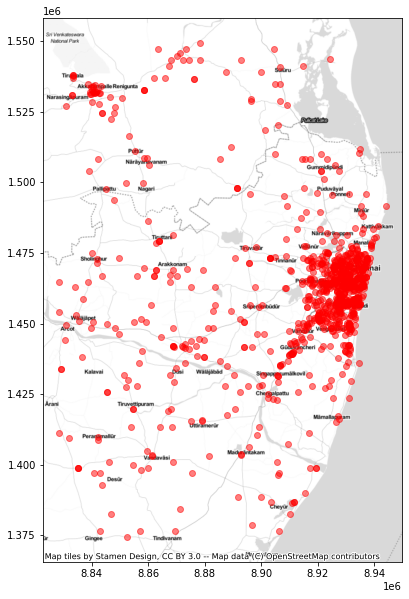

In [35]:
chennai.head()
centroids_i=(np.vstack((chennai["lon"].values, chennai["lat"].values)).T)
coords_ls=[]
for cnt in range(0, 1000):
    p = Point(centroids_i[cnt])
    coords_ls.append(p)

temp2 = gpd.GeoDataFrame(chennai.iloc[:1000], geometry=coords_ls)
temp2.crs = "EPSG:4326"
temp2= temp2.to_crs(epsg=3857)
coords = temp2["geometry"].values
ax=temp2.plot(figsize=(10, 10), color="red", alpha=0.5,
                 legend=True, legend_kwds={'bbox_to_anchor':(.3, 1), 'fontsize':16})
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Positron)

In [10]:
import os
import sys
from copy import copy, deepcopy
from glob import glob
from collections import Counter
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import pyproj
from scipy import stats
from sklearn import cluster

import dask
from dask.distributed import Client
from dask import dataframe as dd

### import mobility libraries
import skmob
import mobilkit

In [42]:
dmin, dmax, lonmin, lonmax, latmin, latmax = dask.compute(chennai.timestamp.min(), 
                                                          chennai.timestamp.max(), 
                                                          chennai.lon.min(), chennai.lon.max(), 
                                                          chennai.lat.min(), chennai.lat.max()
                                                         )

In [43]:
print(mobilkit.loader.fromunix2fulldate(dmin),
      mobilkit.loader.fromunix2fulldate(dmax))
print(lonmin, lonmax, latmin, latmax)

2019-12-31 18:00:01 2020-01-31 17:59:59
79.301208 80.444142 12.243589 13.827116


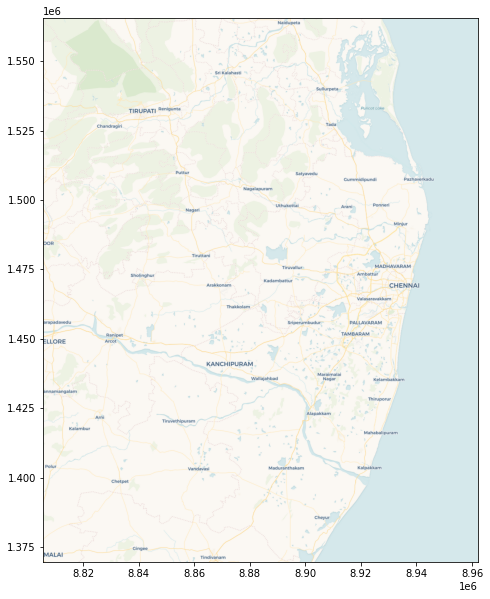

In [45]:
boundary = (lonmin, latmin, lonmax, latmax)
mobilkit.viz.visualize_boundarymap(boundary)

In [146]:
chennai["datetime"] = pd.to_datetime(chennai["timestamp"], unit="s").dt.tz_localize('UTC').dt.tz_convert('Asia/Calcutta')

<ipython-input-146-f1e1da420db9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chennai["datetime"] = pd.to_datetime(chennai["timestamp"], unit="s").dt.tz_localize('UTC').dt.tz_convert('Asia/Calcutta')


In [147]:
%%time
from dask import dataframe as dd 
ddf = dd.from_pandas(chennai, npartitions=2)
ddf_sample = ddf.sample(frac=0.0001).compute()

CPU times: user 1.17 s, sys: 532 ms, total: 1.7 s
Wall time: 1.69 s


In [148]:
len(ddf_sample)

238

In [150]:
ddf_sample

,device_id,lat,lon,timestamp,h3_7_aoi,city,datetime
25677513,7946f383c7f6c5b11ef3ed601f6ca1da,13.404072,80.122722,1578472129,87618eaaeffffff,chennai,2020-01-08 13:58:49+05:30
9093797,63ee12cf158f001de3bf2c0194bbb0f0,13.116696,80.290047,1578027389,87618c49dffffff,chennai,2020-01-03 10:26:29+05:30
806655,2ff2897eb98c4a385f2a043fc564ddef,13.000039,80.238587,1577875886,87618c4f5ffffff,chennai,2020-01-01 16:21:26+05:30
12072403,208b70c018691ecffb647be176d1be5c,12.954182,80.212165,1578147439,87618c4e4ffffff,chennai,2020-01-04 19:47:19+05:30
10990630,4e00be6922b51aa3b5cf41cd8cc78716,13.049968,80.159393,1578120064,87618c4c3ffffff,chennai,2020-01-04 12:11:04+05:30
...,...,...,...,...,...,...,...
44973376,f4d56e4246462223e2ed06119a02536d,13.045262,80.209766,1579086827,87618c4f3ffffff,chennai,2020-01-15 16:43:47+05:30
48094353,ece62444ea6677525e67670043a44e70,13.094722,80.169286,1579218255,87618c4deffffff,chennai,2020-01-17 05:14:15+05:30
43103569,f32343c70fe2cd198a4ae719998eb5b7,13.068272,80.259711,1579018131,87618c488ffffff,chennai,2020-01-14 21:38:51+05:30
63147512,5d9cef0a3be0509aeb0c156d57a7b278,12.906709,80.231726,1580100506,87618c40dffffff,chennai,2020-01-27 10:18:26+05:30


In [151]:
ddf_sample.columns = ["id",'lat', 'lng',"UTC", 'h3_7_aoi', 'city',"datetime"]

In [152]:
ddf.columns

Index(['device_id', 'lat', 'lon', 'timestamp', 'h3_7_aoi', 'city', 'datetime'], dtype='object')

/home/umni2/a/umnilab/apps/Anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


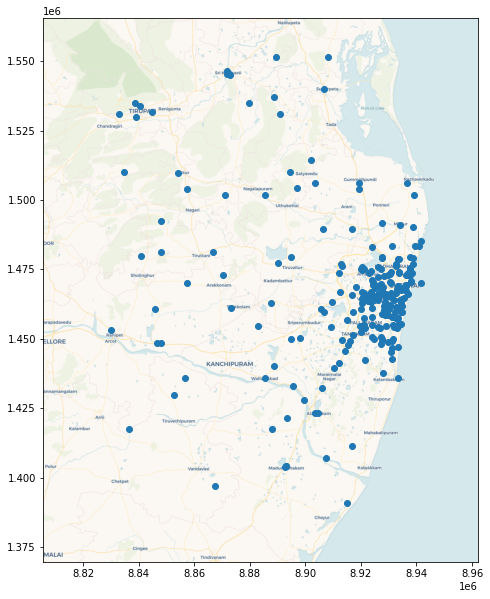

In [153]:
mobilkit.viz.visualize_simpleplot(ddf_sample)

In [154]:
ddf.columns = ["id",'lat', 'lng',"UTC", 'h3_7_aoi', 'city',"datetime"]

In [155]:
ddf_sc = ddf.map_partitions(mobilkit.loader.crop_spatial, boundary)

In [157]:
ddf.head()

,id,lat,lng,UTC,h3_7_aoi,city,datetime
30,cf5dab344621c909a21299b9c5e7d7e0,12.799670,79.820440,1577842019,87618c75cffffff,chennai,2020-01-01 06:56:59+05:30
76,2a0c72fd970743646d7346efba11f41c,13.009125,80.214577,1577902555,87618c4f1ffffff,chennai,2020-01-01 23:45:55+05:30
110,3809ffe2a8c3e546beb62888d6a9cec5,13.130312,80.277604,1577875591,87618c499ffffff,chennai,2020-01-01 16:16:31+05:30
129,a579fd4450c319f1eee844d6d5a007ee,13.036153,80.190334,1577875727,87618c4c6ffffff,chennai,2020-01-01 16:18:47+05:30
146,feac82ad98d2215377a49dd394541d31,13.116500,80.223900,1577876412,87618eb21ffffff,chennai,2020-01-01 16:30:12+05:30


In [158]:
nightendtime = "09:00:00"
nightstarttime = "18:00:00"
timezone = "Asia/Calcutta"
ddf_tc2 = ddf_sc.map_partitions(mobilkit.loader.crop_time,
                                nightendtime,
                                nightstarttime,
                                timezone)

In [169]:
ddf_tc2.head()

,id,lat,lng,UTC,h3_7_aoi,city,datetime,time_t
30,cf5dab344621c909a21299b9c5e7d7e0,12.799670,79.820440,1577842019,87618c75cffffff,chennai,2020-01-01 06:56:59+05:30,1900-01-01 19:26:59
110,3809ffe2a8c3e546beb62888d6a9cec5,13.130312,80.277604,1577875591,87618c499ffffff,chennai,2020-01-01 16:16:31+05:30,1900-01-01 04:46:31
129,a579fd4450c319f1eee844d6d5a007ee,13.036153,80.190334,1577875727,87618c4c6ffffff,chennai,2020-01-01 16:18:47+05:30,1900-01-01 04:48:47
146,feac82ad98d2215377a49dd394541d31,13.116500,80.223900,1577876412,87618eb21ffffff,chennai,2020-01-01 16:30:12+05:30,1900-01-01 05:00:12
152,5e41443b243e73921ffe2a9eed7eae2d,13.098244,80.220107,1577882603,87618c4d2ffffff,chennai,2020-01-01 18:13:23+05:30,1900-01-01 06:43:23


In [93]:
import pytz
datetime.fromtimestamp(1577842019, pytz.timezone("Asia/Calcutta"))

datetime.datetime(2020, 1, 1, 6, 56, 59, tzinfo=<DstTzInfo 'Asia/Calcutta' IST+5:30:00 STD>)

In [159]:
mindays = 7
avgpoints = 1

ddf = ddf.assign(uid=ddf["id"])
users_stats = mobilkit.stats.userStats(ddf).compute()
valid_users = set(users_stats[
                (users_stats["avg"] > avgpoints)
                & (users_stats["daysActive"] > mindays)
                ]["uid"].values)

ddf_clean = mobilkit.stats.filterUsersFromSet(ddf, valid_users)
ddf_clean = ddf_clean[~ddf_clean["datetime"].dt.hour.between(8,19)]

In [161]:
id_home = ddf_clean.groupby("uid").apply(mobilkit.spatial.meanshift)\
                                .compute()\
                                .reset_index()\
                                .rename(columns={0:"home"})
toc = datetime.now()
print("Number of IDs with estimated homes: ",len(id_home))

<ipython-input-161-e0c2f063308e>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  id_home = ddf_clean.groupby("uid").apply(mobilkit.spatial.meanshift)\


Number of IDs with estimated homes:  16330


In [163]:
id_home.head()

,uid,home
0,0006dd681c7a8750f65e0a51114a10e1,"[80.06888475000001, 12.902033750000001]"
1,00217d8386dbc7625fb221763066d1de,"[80.24155472727271, 13.099554000000001]"
2,0027599b62a7911827a95635a634db08,"[80.24600142857143, 13.038176714285713]"
3,003f6d5ff7273fbbfbc986281ed6fc32,"[80.1868117647059, 12.94671711764706]"
4,0052591ca9e3a455907bbb03cced02d3,"[80.23498574999999, 13.05167775]"


In [164]:
id_home["lon"] = id_home["home"].apply(lambda x : x[0])
id_home["lat"] = id_home["home"].apply(lambda x : x[1])
id_home = id_home.drop(columns=["home"])[["uid","lon","lat"]]
id_home.lon = id_home.lon.astype("float64")
id_home.lat = id_home.lat.astype("float64")
id_home.head()

,uid,lon,lat
0,0006dd681c7a8750f65e0a51114a10e1,80.068885,12.902034
1,00217d8386dbc7625fb221763066d1de,80.241555,13.099554
2,0027599b62a7911827a95635a634db08,80.246001,13.038177
3,003f6d5ff7273fbbfbc986281ed6fc32,80.186812,12.946717
4,0052591ca9e3a455907bbb03cced02d3,80.234986,13.051678


In [165]:
id_home.to_csv("/home/bridge/c/mittal53/Documents/WB_Chennai/"+"id_home_"+str(mindays)+"_"+str(avgpoints)+"_Jan".replace(".","")+".csv", index=None)

In [173]:
idhome_gdf = gpd.GeoDataFrame(id_home, geometry=gpd.points_from_xy(id_home.lon, id_home.lat))
idhome_gdf.crs = "EPSG:4326"

In [ ]:
### load shape data
areas = ["09_Manzanas_INV2016_shp","17_Manzanas_INV2016_shp",
         "21_Manzanas_INV2016_shp","29_Manzanas_INV2016_shp"]
manz_shp = gpd.GeoDataFrame()
for i,a in enumerate(areas):
    manz_f = "data/spatial/manzanas_shapefiles/"+a+"/"
    manz_shp1 = gpd.read_file(manz_f)
    manz_shp = manz_shp.append(manz_shp1, ignore_index=True)
    print("done",i)

In [175]:
wards = gpd.read_file("/home/umni2/a/umnilab/data/WB_India_otherdata/OneDrive_2_3-29-2021/TAZ_Job_Pop_SqM.shp")
wards["index"] = np.linspace(0, wards.shape[0]-1, wards.shape[0]).astype(int)

<AxesSubplot:>

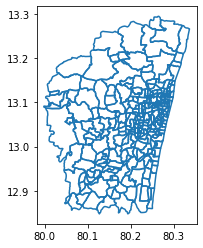

In [170]:
wards.boundary.plot()

In [176]:
wards.head()

,POPULATION,EMPLOYMENT,AreaSm,TAZ,Shape_Leng,Shape_Area,geometry,index
0,18668,7078,609588,65,0.032960,0.000051,"POLYGON ((80.21518 13.06354, 80.21590 13.06327...",0
1,56627,26066,809125,29,0.034187,0.000067,"POLYGON ((80.22204 13.06150, 80.22189 13.06112...",1
2,23612,9924,367244,42,0.023051,0.000031,"POLYGON ((80.25866 13.09909, 80.25848 13.09669...",2
3,16091,16287,575000,101,0.032789,0.000048,"POLYGON ((80.28495 13.09172, 80.28503 13.09225...",3
4,20878,21650,896056,102,0.046630,0.000075,"POLYGON ((80.28203 13.08617, 80.28271 13.08693...",4


In [177]:
id_wards = gpd.sjoin(idhome_gdf, wards, how="inner", op='within')
id_wards.head()

,uid,lon,lat,geometry,index_right,POPULATION,EMPLOYMENT,AreaSm,TAZ,Shape_Leng,Shape_Area,index
0,0006dd681c7a8750f65e0a51114a10e1,80.068885,12.902034,POINT (80.06888 12.90203),231,23820,5798,20785275,251,0.27134,0.001731,231
158,04b789a8451faee09ca369a4c89cd3c4,80.061755,12.898037,POINT (80.06175 12.89804),231,23820,5798,20785275,251,0.27134,0.001731,231
769,181ae871b41edc51eab168e89abac728,80.067881,12.907713,POINT (80.06788 12.90771),231,23820,5798,20785275,251,0.27134,0.001731,231
828,19beec0cc3420ccf0ebed6b8608d5107,80.073515,12.910194,POINT (80.07351 12.91019),231,23820,5798,20785275,251,0.27134,0.001731,231
1091,2269e79edd319b64bb604049025d73d9,80.077414,12.921301,POINT (80.07741 12.92130),231,23820,5798,20785275,251,0.27134,0.001731,231


In [192]:
df_pop = id_wards.groupby("index")["uid"].count()
df_pop = df_pop.reset_index()
df_pop.head()

,index,uid
0,0,41
1,1,52
2,2,19
3,3,17
4,4,9


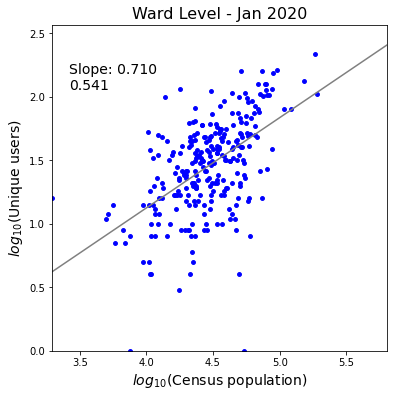

In [270]:
wards = wards.sort_values(by="index")
df_pop = df_pop.sort_values(by="index")
wards["logpop"] = np.log10(wards["POPULATION"])
wards["loguser"] = np.log10(df_pop["uid"])        
wards = wards.replace([np.inf, -np.inf], np.nan).dropna()
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(wards["logpop"].values, wards["loguser"].values, color="b", s=15)
c1, i1, s1, p_value, std_err = stats.linregress(wards["logpop"].values, wards["loguser"].values)
ax.plot([0,np.max(wards["logpop"])*1.1],[i1,i1+np.max(wards["logpop"])*1.1*c1], 
        linestyle="-", color="gray")   
ax.set_xlim(np.min(wards["logpop"]),np.max(wards["logpop"])*1.1)
ax.set_ylim(0,np.max(wards["loguser"])*1.1)
ax.set_xlabel(r"$log_{10}$(Census population)", fontsize=14)
ax.set_ylabel(r"$log_{10}$(Unique users)", fontsize=14)
ax.annotate("Slope: "+str(c1)[:5]+"\n"+str(s1)[:5], #+utils.stars(p_value), 
                    xy=(.05,0.8), 
                    xycoords='axes fraction', color="k", fontsize=14)
ax.set_title("Ward Level - Jan 2020", fontsize=16)
plt.savefig("/home/bridge/c/mittal53/Documents/WB_Chennai/Figures/representativeness1.png", bbox_inches="tight",dpi=300)
plt.show()

In [204]:
wards["rate"] = df_pop["uid"].values*100/wards.POPULATION.values

In [260]:
import matplotlib
def scale(ax):
    x, y, scale_len = 8938000,1445000, 5000 #arrowstyle='-'
    scale_rect = matplotlib.patches.Rectangle((x,y),scale_len,200,linewidth=3,edgecolor='k',facecolor='k')
    ax.add_patch(scale_rect)
    plt.text(0.9, 0.11, s='5 KM', fontsize=14, horizontalalignment='center', transform=ax.transAxes)

In [279]:
chennai_boundary = gpd.read_file("/home/bridge/c/mittal53/Documents/WB_Chennai/Data_files/chennai_boundary/chennai_boundary.shp")
chennai_boundary.crs = "EPSG:4326"
chennai_boundary = chennai_boundary.to_crs(epsg=3857)

<ipython-input-280-e56d4ed58291>:9: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)


0.0018563552321372218
0.10592596951685988


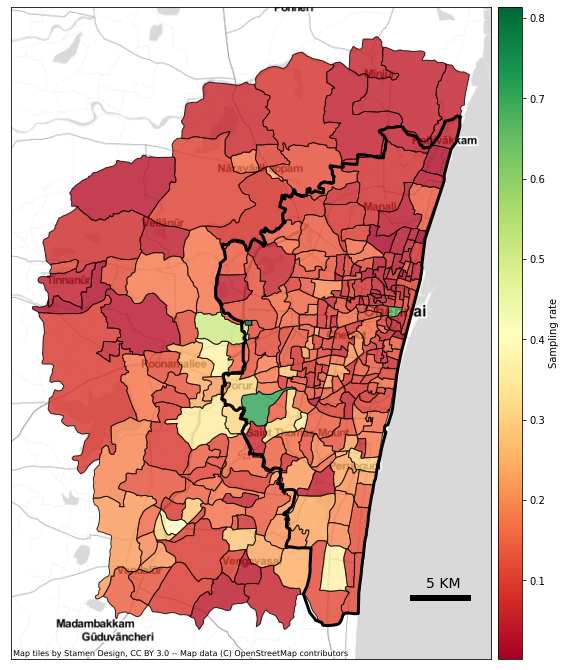

In [280]:
fig,ax = plt.subplots(figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
wards2 = wards.to_crs(epsg=3857)
ax.set(aspect='equal', xticks=[], yticks=[])
wards2.plot(ax=ax, column='rate', cmap='RdYlGn', legend=True, 
                    cax=cax, legend_kwds={'label': "Sampling rate"}, alpha=0.8, edgecolor="black")
chennai_boundary.plot(ax=ax, color="None", edgecolor="black",linewidth=3)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
scale(ax)
plt.savefig("/home/bridge/c/mittal53/Documents/WB_Chennai/Figures/representativeness2.png", bbox_inches="tight",dpi=300)

print(np.min(wards["rate"].values))
print(np.median(wards["rate"].values))

In [1]:
fig,ax = plt.subplots(figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
wards2 = wards.to_crs(epsg=3857)
ax.set(aspect='equal', xticks=[], yticks=[])
wards2.plot(ax=ax, column='POPULATION', cmap='Blues', legend=True, 
                    cax=cax, legend_kwds={'label': "Population"}, alpha=0.8, edgecolor="black")
chennai_boundary.plot(ax=ax, color="None", edgecolor="black",linewidth=3)
id_wards2 = id_wards.to_crs(epsg=3857)
id_wards2.plot(ax=ax, color="red", markersize=2)
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Positron)
scale(ax)
plt.savefig("/home/bridge/c/mittal53/Documents/WB_Chennai/Figures/population_homes.png", bbox_inches="tight",dpi=300)

print(np.min(wards["rate"].values))
print(np.median(wards["rate"].values))

NameError: name 'plt' is not defined

In [283]:
np.median(gpd.sjoin(chennai_boundary, wards2, how='inner', op='intersects')["rate"].values)

0.10580004114731067

In [4]:
path = '/home/umni2/a/umnilab/data/WB_India2'
all_dates = []
files = os.listdir(path)
for f in files:
    all_dates.append(f)

In [28]:
path = '/home/umni2/a/umnilab/data/WB_India2/'
month = "01"
year_ = 2020
mindays = 7
avgpoints = 1

overall_users = []
final_users = []
med_rep = []
slopes = []
corr_coef = []

# for counter in range(0, 12+4):
for counter in range(0, 12+4):
    month = str(counter+1)
    year = str(year_)
    if counter+1>12:
        month = str(counter+1-12)
        year = str(year_+1)
        if counter+1-12<10:
            month = "0" + str(counter+1-12)
    if counter+1<10:
        month = "0" + str(counter+1)
    print(month, year)
    dates = []
    for cnt in range(0, 31):
        day = str(cnt+1)
        if cnt+1<10:
            day = "0" + str(cnt+1)
        f_now = "date="+year+"-"+month+"-"+day
        if f_now in all_dates:
            dates.append(f_now)
    added = 0
    for cnt in range(0, len(dates)):
        print(dates[cnt])
        path_ = path+dates[cnt]
        files = os.listdir(path_)
        for f in files:
            if ".snappy.parquet" in f:
                table2 = pq.read_table(path_+'/'+f)
                file = table2.to_pandas()
                file = file[file.city=="chennai"]
                if added==0:
                    df = file
                    added = added + 1
                else:
                    df = df.append(file, ignore_index=True)
    chennai = df[df.city=="chennai"]
    chennai["datetime"] = pd.to_datetime(chennai["timestamp"], unit="s").dt.tz_localize('UTC').dt.tz_convert('Asia/Calcutta')
    overall_users.append(len(chennai["device_id"].unique()))
    ddf = dd.from_pandas(chennai, npartitions=2)
    ddf.columns = ["id",'lat', 'lng',"UTC", 'h3_7_aoi', 'city',"datetime"]
    ddf = ddf.assign(uid=ddf["id"])
    users_stats = mobilkit.stats.userStats(ddf).compute()
    valid_users = set(users_stats[
                    (users_stats["avg"] > avgpoints)
                    & (users_stats["daysActive"] > mindays)
                    ]["uid"].values)
    ddf_clean = mobilkit.stats.filterUsersFromSet(ddf, valid_users)
    ddf_clean = ddf_clean[~ddf_clean["datetime"].dt.hour.between(8,19)]
    id_home = ddf_clean.groupby("uid").apply(mobilkit.spatial.meanshift)\
                                    .compute()\
                                    .reset_index()\
                                    .rename(columns={0:"home"})
#     toc = datetime.now()
#     print("Number of IDs with estimated homes: ",len(id_home))
    final_users.append(len(id_home))
    id_home["lon"] = id_home["home"].apply(lambda x : x[0])
    id_home["lat"] = id_home["home"].apply(lambda x : x[1])
    id_home = id_home.drop(columns=["home"])[["uid","lon","lat"]]
    id_home.lon = id_home.lon.astype("float64")
    id_home.lat = id_home.lat.astype("float64")
    idhome_gdf = gpd.GeoDataFrame(id_home, geometry=gpd.points_from_xy(id_home.lon, id_home.lat))
    idhome_gdf.crs = "EPSG:4326"
    wards = gpd.read_file("/home/umni2/a/umnilab/data/WB_India_otherdata/OneDrive_2_3-29-2021/TAZ_Job_Pop_SqM.shp")
    wards["index"] = np.linspace(0, wards.shape[0]-1, wards.shape[0]).astype(int)
    id_wards = gpd.sjoin(idhome_gdf, wards, how="inner", op='within')
    df_pop = id_wards.groupby("index")["uid"].count()
    df_pop = df_pop.reset_index()
    wards = wards.sort_values(by="index")
    df_pop = df_pop.sort_values(by="index")
    wards["logpop"] = np.log10(wards["POPULATION"])
    wards["loguser"] = np.log10(df_pop["uid"])        
    wards = wards.replace([np.inf, -np.inf], np.nan).dropna()
    c1, i1, s1, p_value, std_err = stats.linregress(wards["logpop"].values, wards["loguser"].values)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(wards["logpop"].values, wards["loguser"].values, color="b", s=15)
    ax.plot([0,np.max(wards["logpop"])*1.1],[i1,i1+np.max(wards["logpop"])*1.1*c1], 
            linestyle="-", color="gray")   
    ax.set_xlim(np.min(wards["logpop"]),np.max(wards["logpop"])*1.1)
    ax.set_ylim(0,np.max(wards["loguser"])*1.1)
    ax.set_xlabel(r"$log_{10}$(Census population)", fontsize=14)
    ax.set_ylabel(r"$log_{10}$(Unique users)", fontsize=14)
    ax.annotate("Slope: "+str(c1)[:5]+"\n"+str(s1)[:5], #+utils.stars(p_value), 
                        xy=(.05,0.8), 
                        xycoords='axes fraction', color="k", fontsize=14)
    ax.set_title("Ward Level - Jan 2020", fontsize=16)
    plt.show()
    wards["rate"] = df_pop["uid"].values*100/wards.POPULATION.values
    med_rep.append(wards["rate"].values)
    slopes.append(c1)
    corr_coef.append(s1)
    del df
    del chennai

03 2020
date=2020-03-01
date=2020-03-02
date=2020-03-03
date=2020-03-04
date=2020-03-05
date=2020-03-06
date=2020-03-07
date=2020-03-08
date=2020-03-09
date=2020-03-10
date=2020-03-11
date=2020-03-12
date=2020-03-13
date=2020-03-14
date=2020-03-15
date=2020-03-16
date=2020-03-17
date=2020-03-18
date=2020-03-19
date=2020-03-20
date=2020-03-21
date=2020-03-22
date=2020-03-23
date=2020-03-24
date=2020-03-25
date=2020-03-26
date=2020-03-27
date=2020-03-28


MemoryError: Unable to allocate 4.96 GiB for an array with shape (2, 332718233) and data type object

In [24]:
overall_users

[338314, 411247]

In [25]:
final_users

[16330, 30388]

In [23]:
med_rep

[array([0.21962717, 0.09182899, 0.08046756, 0.10564912, 0.04310758,
        0.04924491, 0.03540324, 0.0369191 , 0.08957363, 0.09206408,
        0.0414144 , 0.04408361, 0.04533297, 0.06768517, 0.04360676,
        0.10567411, 0.02220347, 0.02383894, 0.02937548, 0.22141707,
        0.13927577, 0.13472403, 0.17383746, 0.15313936, 0.14735561,
        0.12875301, 0.04698899, 0.01905407, 0.02175775, 0.10762683,
        0.13048017, 0.03749161, 0.10384216, 0.15718068, 0.06421822,
        0.17159334, 0.17726568, 0.22124873, 0.24778761, 0.12253494,
        0.14316932, 0.14195057, 0.11442655, 0.1413399 , 0.22453169,
        0.12362275, 0.07372389, 0.08249549, 0.0889558 , 0.08323541,
        0.03723701, 0.03088708, 0.0370062 , 0.06646036, 0.15816047,
        0.05254861, 0.10491214, 0.11855833, 0.07331205, 0.09540569,
        0.0476489 , 0.11551984, 0.07603406, 0.19728941, 0.13084394,
        0.07434094, 0.07060277, 0.10037197, 0.01883417, 0.06690806,
        0.05523641, 0.01337614, 0.03748477, 0.07

In [26]:
slopes

[0.7102795581221234, 0.7281391848658174]

In [27]:
corr_coef

[0.5412512439388245, 0.5841832194816909]